# Variational Autoencoder (VAE)

Curso ML: Gómez and Camilion

In [ ]:
#%pip list
#%pip install jax flax optax numpy matplotlib
#%pip install tensorflow

In [1]:
import jax as jax
from flax import nnx
import optax                           
import tensorflow as tf 

import jax.numpy as jnp
import matplotlib.pyplot as plt
#plt.style.use("../style.pyplot")

2025-02-18 14:29:36.370514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 14:29:36.437797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 14:29:36.456608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 14:29:37.734736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# About VAEs

* Encoder/Decoder (Autoencoder).
* Sampling from a latent space.
* Structured manifold.
* Concept vectors.


The key idea of image generation is to develop a low-dimensional latent space of representations  where any
point can be mapped to a “valid” data point. Once such a latent space has been learned, you can sample
points from it, and, by mapping them back to the original data space, generate new data that have
never been registered before.

VAEs are useful for learning latent spaces that are well structured and continuous, where specific 
directions encode a meaningful axis of variation in the data. 

A VAE turns the data into the parameters of a statistical distribution: a mean and a
variance. Essentially, this means we’re assuming the input has been generated
by a statistical process, and that the randomness of this process should be taken into
account during encoding and decoding. The VAE then uses the mean and variance
parameters to randomly sample one element of the distribution, and decodes that
element back to the original input. The stochasticity of this process improves robustness 
and forces the latent space to encode meaningful representations everywhere: every point sampled
 in the latent space is decoded to a valid output.


## A typical Workflow

* An **encoder**  turns the input data,  into two vectors in a latent space of representations (mean $\boldsymbol{\mu}$ and variance $\boldsymbol{\sigma}$).
* You randomly **sample** a point $\mathbf{z}$ from the latent normal distribution that’s
assumed to generate the input image: $$\mathbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma} \mathcal{N}(\mathbf{0},\mathbf{1}).$$
* A **decoder**  maps $\mathbf{z}$  in the latent space back to the original input space.



We will learn $\textrm{log}(\sigma^2)$, then $\mathbf{z} =  \boldsymbol{\mu} + e^{\frac{1}{2}\mathrm{log}(\sigma^2)} \mathcal{N}(\mathbf{0},\mathbf{1})$.

The training is **unsupervised**, since it only uses the input data.

## The loss function

The loss function has two components: a **reconstruction loss** and a **regularization loss** (the Kullback-Leibler divergence for Gaussian latens): $$\mathcal{L} = \mathcal{L}_R + \mathcal{L}_{KL}.$$

* The reconstruction loss is the binary crossentropy. 
* The regularization loss is $\mathcal{L}_{KL}(W) = \frac{1}{2} \sum_j \left( 1 + \log(\sigma_j^2) - \sigma_j^2  -\mu_j^2 \right).$

The  reconstruction loss forces the decoded samples to match the initial inputs, and the regularization loss helps learn well-rounded latent distributions and reduces overfitting to the training data.



> Next, we are going to code, train, and deploy a VAE for the classical problem of generating more MNIST digits.

# Example

In [2]:
# Model

class Encoder(nnx.Module):
  """VAE Encoder."""
  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    self.linear       = nnx.Linear(din,dmid,rngs=rngs)
    self.linear_out_1 = nnx.Linear(dmid,dout,rngs=rngs)
    self.linear_out_2 = nnx.Linear(dmid,dout,rngs=rngs)  
    
  def __call__(self, x):
    x        = self.linear(x)
    x        = nnx.relu(x)
    mean_x   = self.linear_out_1(x)
    logvar_x = self.linear_out_2(x)
    return mean_x, logvar_x


class Decoder(nnx.Module):
  """VAE Decoder."""
  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    self.linear       = nnx.Linear(din,dmid,rngs=rngs)
    self.linear_out   = nnx.Linear(dmid,dout,rngs=rngs)
    
  def __call__(self, z):
    z = self.linear(z)  # latents -> 500
    z = nnx.relu(z)
    z = self.linear_out(z) # 500 -> 28 x 28 = 784    
    return z


class VAE(nnx.Module):
  """Full VAE model."""

  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    self.encoder = Encoder(din, dmid, dout, rngs=rngs)
    self.decoder = Decoder(dout, dmid, din, rngs=rngs) 
    
  def __call__(self, x, zrng):
    mean, logvar = self.encoder(x)
    std = jnp.exp(0.5 * logvar)    
    eps = jax.random.normal(zrng, logvar.shape)    
    z   = mean + std * eps        
    recon_x = self.decoder(z)
    return recon_x, mean, logvar

  def generate(self, z):
    return nnx.sigmoid(self.decoder(z))

In [3]:
# Losses

@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))


@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = nnx.log_sigmoid(logits)
  return -jnp.sum(
      labels * logits + (1.0 - labels) * jnp.log(-jnp.expm1(logits))
  )
# The expression is loss =  - 1/N sum_j { y_j log(p_j) + (1-y_j) * log( 1- p_j) 
# Here, p_j is given by sigmoid(.) .
# The term jnp.log(-jnp.expm1(logits)) is equal to log(1 - sigmoid(.)) when logits = log(sigmoid(.))
# log_sigmoid calculates log(sigmoid(.)) = - log(1+exp(-.))
# expm1 calculates exp(.)-1 of each element of the input.


In [4]:
def ManifoldInterpolation(X0,X1,steps=10):
    # HOW to denormalize the results ?
    assert X0.shape == X1.shape

    nx,ny,_ = X0.shape
    
    x0_mu,x0_logvar = model.encoder(X0.flatten())
    x1_mu,x1_logvar = model.encoder(X1.flatten())

    output = []

    for w in jnp.linspace(0,1, steps):
    
        w0, w1    = (1. - w), w
        x_mean    = x0_mu     * w0 + x1_mu     * w1 
        x_logvar  = x0_logvar * w0 + x1_logvar * w1

        z   = x_mean + jnp.exp(0.5 * x_logvar)    
        
        #output.append(model.generate(z).reshape(nx,ny).T)  # mind the transposition !
        output.append(model.generate(z).reshape(nx,ny))  

    return jnp.array(output)


def LinearInterpolation(X0,X1,steps=10):
    
    assert X0.shape == X1.shape

    nx,ny,_ = X0.shape
    
   
    output = []

    for w in jnp.linspace(0,1, steps):
    
        w0, w1    = (1. - w), w
        
        output.append(X0 * w0 + X1 * w1) # denormalizing here is easy: Denormalize(X0) * w0 + Denormalize(X1) * w1

    return jnp.array(output)



In [5]:
def MaxMinScaler(X,min=0., max=1.):
    X_std = (X - X.min(axis=[1,2],keepdims=True)) / (X.max(axis=[1,2],keepdims=True) - X.min(axis=[1,2],keepdims=True))    
    return X_std * (max - min) + min


In [6]:
def Plot(X,vmin=None,vmax=None):
    plt.figure(figsize=(3,3))
    plt.imshow(X.squeeze(),cmap="gray",vmin=vmin,vmax=vmax, interpolation = None)
    plt.axis("off")
    #plt.colorbar(shrink=0.4)
    plt.colorbar(orientation='horizontal', shrink=0.6,pad=0.04,ticks=[vmin,0,vmax])#.set_label('[--]')
    plt.show()
    return None

def PlotSub(X,vmin=None,vmax=None):
    plt.imshow(X.squeeze(),cmap="gray",vmin=vmin,vmax=vmax, interpolation = None)
    plt.axis("off")
    plt.colorbar(orientation='horizontal', shrink=0.6,pad=3*-0.04,ticks=[vmin,0,vmax])#.set_label('[--]')
    return None


# Data

Normalizing
Scale factor is 6188.26318359375
The dataset is (256, 1024, 1024, 1)
There are 256 examples of 1024x1024 images with 1 channel.
Data goes between 0.000 and 1.000


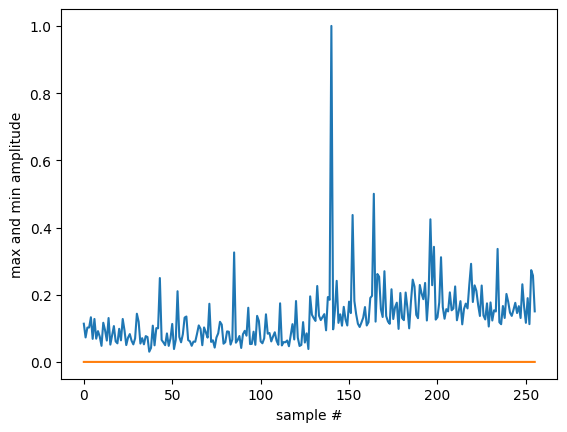

In [7]:
data_1 = jnp.load("/home/chris/projects/ml/Y-TEC/medios_1024cont/X_1024L_ICS_2.npy") # load the dataset
data_2 = jnp.load("/home/chris/projects/ml/Y-TEC/medios_1024cont/X_1024L_HCS_2.npy") # load the dataset
data   = jnp.concatenate([data_1, data_2], axis=0)    # use all available images
data   = jnp.expand_dims(data, axis=-1)  # put "1" in the last dimension (number of channels)

# # fake data
# zrng            = nnx.Rngs(1).params() # set a random number generator seed 
# data_1 = jax.random.normal(zrng, [50,1024,1024])
# data_2 = jax.random.normal(zrng, [50,1024,1024])
# data   = jnp.concatenate([data_1, data_2], axis=0)    # use all available images
# data   = jnp.expand_dims(data, axis=-1)  # put "1" in the last dimension (number of channels)
# #data   = jax.random.normal(zrng, [100,1024,1024,1]) 

# # downsample
# DOWNSAMPLE = False
# CUT        = False
#
# if DOWNSAMPLE:
#     B,W,H,C = data.shape
#     print(f"Downsampling to {W//4} x{ H//4}")    
#     data = jax.image.resize(data,(B,W//4,H//4,C),method="cubic",antialias=True)
#
# if CUT:
#     print("Cutting each image")
#     #data = data[:,:64,:64,:]
#     data = data[:,:128,:128,:]
# #data = jnp.log(data) # take the log_e of the data 

#data = jnp.expand_dims(data, axis=-1).astype(jnp.float32)/255.0 # normalize to [0,+1] (a nice range for a sigmoid(.) )
N = data.shape[0]

how_many_nans = jnp.sum(jnp.isnan(data),axis=[0,1,2,3]) # how many NaNs are present ?

#data0 = jnp.copy(data) # to use max and min of the true images to compare results of decoding with true images

# Normalizing
print("Normalizing")
data_N  =  jnp.abs(data).max() #data_N  =  jnp.abs(data).max(axis=[0,1,2,3],keepdims=True) #.reshape(-1,1,1,1)
##data_N  =  data.mean(axis=[1,2,3],keepdims=True) #.reshape(-1,1,1,1) # This brings hell !
#data_N  =  jnp.abs(data).max(axis=[1,2,3],keepdims=True) #.reshape(-1,1,1,1)
print(f"Scale factor is {data_N}")
data = data / data_N   # normalize to [0,+1] (a nice range for a sigmoid(.) )
#data  = MaxMinScaler(data,0.01,1)

if how_many_nans > 0 : print(f"Warning!: There are {how_many_nans} NaNs in the dataset")      

print(f"The dataset is {data.shape}")  # [ batch, W, H, channels]
print(f"There are {data.shape[0]} examples of {data.shape[1]}x{data.shape[2]} images with {data.shape[-1]} channel.")
print(f"Data goes between {data.min():.3f} and {data.max():.3f}")


# Check that EACH image is between 0 and 1

plt.figure()
plt.plot(data.max(axis=[1,2,3],keepdims=True).squeeze())
plt.plot(data.min(axis=[1,2,3],keepdims=True).squeeze())
plt.xlabel("sample #")
plt.ylabel("max and min amplitude")
plt.show()

In [8]:
del data_1
del data_2

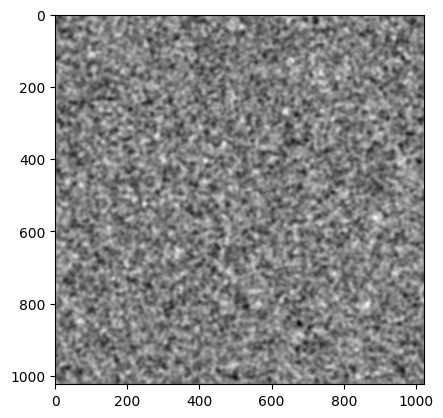

In [ ]:
plt.imshow(jnp.log(data)[0], cmap='binary')#, vmin=-.5, vmax=.5) 


In [12]:
# Histogram without and with log()
# Note: a map with a lognormal density turns into a map with a Gaussian density
'''for kmap in [data_1[0],data_2[0]]:
    kmap = kmap.flatten()
    plt.figure(figsize=(11,5))
    plt.subplot(1,2,1)
    plt.ylabel("Counts")
    plt.hist(kmap, histtype='step',color="black")
    plt.xlabel(r"$K$")
    plt.subplot(1,2,2)
    plt.hist(jnp.log(kmap), histtype='step',color="black")
    plt.xlabel(r"$\log(K)$")
    plt.show()'''

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_38709/1103306026.py:3: SyntaxWarning: invalid escape sequence '\l'
  '''for kmap in [data_1[0],data_2[0]]:


'for kmap in [data_1[0],data_2[0]]:\n    kmap = kmap.flatten()\n    plt.figure(figsize=(11,5))\n    plt.subplot(1,2,1)\n    plt.ylabel("Counts")\n    plt.hist(kmap, histtype=\'step\',color="black")\n    plt.xlabel(r"$K$")\n    plt.subplot(1,2,2)\n    plt.hist(jnp.log(kmap), histtype=\'step\',color="black")\n    plt.xlabel(r"$\\log(K)$")\n    plt.show()'

In [ ]:
# Mean and std of each map in the training set:

#data_means = [ data[k].mean() for k in range(len(data))]

'''for tmp,color in [[data0,"black"],[data,"orange"]]:
    #tmp       = jnp.log(tmp)
    tmp_mu    = tmp.mean(axis=[1,2,3],keepdims=True)
    tmp_sigma = tmp.std(axis=[1,2,3],keepdims=True)
    plt.figure(figsize=(11,3))
    plt.subplot(1,2,1)
    plt.plot(tmp_mu.squeeze(),color=color)
    plt.xlabel("sample #")
    plt.title(r"$\mu$")
    plt.subplot(1,2,2)
    plt.plot(tmp_sigma.squeeze(),color=color)
    plt.xlabel("sample #")
    plt.title(r"$\sigma$")
    plt.show()'''

In [ ]:
# # check histogram of  images (before processing) 
# plt.figure(figsize=(3,3))
# for k in jnp.arange(data_1.shape[0]): #[0,-1]:
# #for k in [0,-1]:

#     plt.hist(data_1[k].flatten(),bins=50,alpha=0.3,color="gray", histtype='step');
#     plt.hist(data_2[k].flatten(),bins=50,alpha=0.3,color="gray", histtype='step');
#     #plt.hist(data_3[k].flatten(),bins=50,alpha=0.3,color="gray");
# plt.show()

# # histograms after normalizing (and a possible decimation)

# plt.figure(figsize=(3,3))
# for k in jnp.arange(data.shape[0]): #[0,-1]:
#     plt.hist(data[k].flatten(),bins=50,alpha=0.8,color="gray", histtype='step');
# plt.show()   


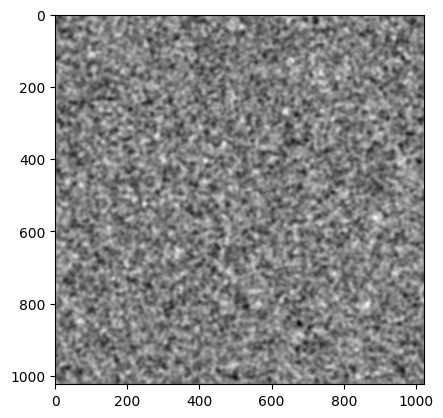

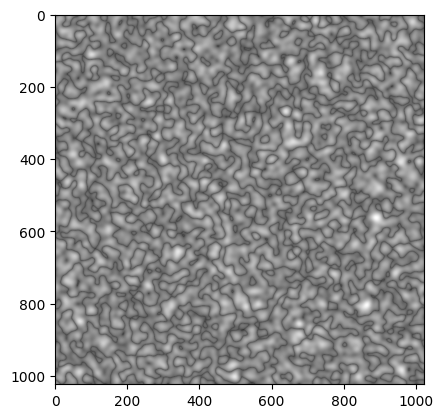

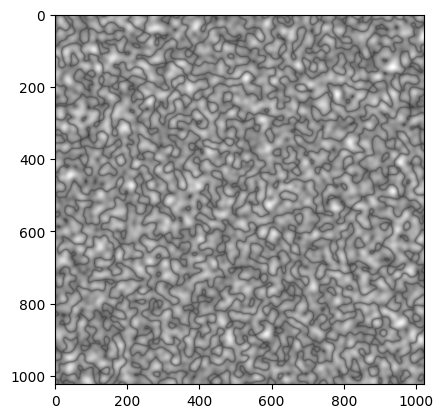

In [13]:
# see some images
for k in [0, N//2, -1]:
    plt.imshow(jnp.log(data[k]), cmap='binary')#, vmin=-5, vmax=5)
    plt.show()
    #Plot(np.log(data[k]),vmin=data[0].min(),vmax=data[0].max());  # pay attention on vmin and vmax 

# Train


We assume  `latents`-dimensional vectors. Here we use a 2-D space, so $\mathbf{z}=(z_1,z_2)^T$, $\boldsymbol{\mu}=(\mu_1,\mu_2)^T$, and $\boldsymbol{\sigma}=(\sigma_1,\sigma_2)^T$.

* The model is a dense network that vectorizes the $N\times N$ images  into vectors  of $N^2$ components.
* The images are normalized into the range $[0,+1]$, so we will use a `sigmoid()` when recontructing the  result of the decoder.

In [9]:
config = {"learning_rate": 1e-6,  # reduce when image is 1024x1024
          "batch_size": 8,
          "num_epochs": 1,
          "din": 1024*1024, # it was 64*64
          "dmid": 250, # should be much larger that 256*256. It was 500 for 64x64
          "latents": 1*1024 # 2*64         
          }

In [10]:
rng             = nnx.Rngs(0)          # set a random number generator seed 
zrng            = nnx.Rngs(1).params() # set a random number generator seed 

din, dmid, dout = config["din"],config["dmid"],config["latents"]
learning_rate   = config["learning_rate"]

model     = VAE(din, dmid, dout,  rngs = rng)  # eager initialization


optimizer = nnx.Optimizer( model, optax.adam(learning_rate) ) #  reference sharing

@nnx.jit # automatic state management
def train_step(model, optimizer, x, zrng):
  def loss_fn(model):
    recon_x, mean, logvar = model(x,zrng) # call methods directly

    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    loss = bce_loss + kld_loss
    return loss
  
  loss_val, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  #  inplace updates
  return loss_val

In [11]:
# Dataset

tf.random.set_seed(0)  # set random seed for reproducibility
dataset = tf.data.Dataset.from_tensor_slices(data) # Use all images
dataset = dataset.shuffle(buffer_size=1024).batch(config["batch_size"])

In [ ]:
# Check the model gives numbers
#model.encoder(data[0].flatten()) 

In [ ]:
# Training

print("Training ...")

model     = VAE(din, dmid, dout,  rngs = rng)  # eager initialization
optimizer = nnx.Optimizer( model, optax.adam(learning_rate) ) #  reference sharing


history = []
key     = jax.random.key(0) # to draw new samples from the eps = N(0,1) on reconstruction  
#subkey  = jax.random.key(0) # to always draw the same N(0,1)

#config["num_epochs"] = 100

for epoch in jnp.arange(config["num_epochs"]):
   
    # To make a new key at every epoch (same key for all the minibatches that follow):
    key, subkey = jax.random.split(key) 

    #for batch in dataset:  # then use batch = batch.numpy() # to go from a TF object to a numpy one.
    for batch in dataset.as_numpy_iterator():
        
        ## To make a new key for every minibatch (ergo, also for every epoch): 
        key, subkey = jax.random.split(key) 

        loss_val = train_step(model, optimizer, batch.reshape(-1,config["din"]), subkey)    
    history.append(loss_val)
    if (epoch +1 ) % 10 == 0: print(f" Epoch {epoch+1} : loss = {loss_val:.3f}")
print("Done.")


#  loss over epochs
#history = jnp.array(history)
plt.figure(figsize=(5,5))
plt.plot(history,color="gray",lw=3)
plt.xlabel(r"Epoch $k$")
plt.ylabel(r"$\mathcal{L}(W_k)$")
plt.show()

Training ...


2025-02-18 14:31:49.434881: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.


In [ ]:
# Check that the trained model gives numbers. For example, if the learning rate is too large, this gives NaN after training.
model.encoder(data[0].flatten()) 

# Sampling


We will sample a grid of points in the latent space to visualize the smooth continuity of this space on the generated images.

In [ ]:
# How to use the VAE to generate:

z         = jnp.zeros(config["latents"]) # The vector z in the latent space.
x_decoded = model.generate(z)  # Decode z into an image.

# Plot

nx = int(jnp.sqrt(config["din"]))
plt.figure(figsize=(4,4))
#plt.title(f"$z=$ {z}",fontsize=11)
plt.imshow(x_decoded.reshape(nx,nx),cmap="gray",vmin=0,vmax=+1)
plt.axis("off")
plt.show()

## Manifold interpolation vs. linear interpolation

<!-- * primero tomar el log. Entreno
* calcular el hist de las interpoladas. Obtener la std de ajustar una Gaussiana. -->

In [ ]:
#output_vae = ManifoldInterpolation(data[0],data[-1],steps).squeeze()
#output_vae = jnp.heaviside(output_vae-output_vae.mean(axis=[1,2],keepdims=True),0)
#plt.imshow(output_vae[2].squeeze(),cmap="bone");

In [ ]:
# Interpolation between two images from the dataset:

digit_size = data.shape[1]

steps    = len(data) # means steps - 2 interpolated images4
steps    =  10

# use the same decoded image for linear interpolation:
I0,I1 = data[0],data[-1]
mu,logvar = model.encoder(I0.flatten())
img0      = model.generate(mu + jnp.exp(0.5 * logvar)).reshape(digit_size,digit_size,1)
mu,logvar = model.encoder(I1.flatten())
img1      = model.generate(mu + jnp.exp(0.5 * logvar)).reshape(digit_size,digit_size,1)

output_vae = ManifoldInterpolation(I0,I1,steps).squeeze()
#output_lin = LinearInterpolation(I0,I1,steps).squeeze() # using the training images
output_lin = LinearInterpolation(img0,img1,steps).squeeze() # using the decoded images

# See strip of images

for img in [output_vae,output_lin]:

    img_int  = jnp.array(img).reshape(steps*digit_size,digit_size) # * data_N

    # Plot results

    plt.figure(figsize=(20, 15))
    plt.imshow(img_int.T,cmap="gray",interpolation=None,vmin=0,vmax=I0.max()) # mind the vmin, vmax !
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.show()


# means of each image

#data_means       = [ data[k].mean() for k in range(len(data))]
#output_vae_means = [ output_vae[k].mean()  for k in range(len(output_vae))]
#output_lin_means = [ output_lin[k].mean()  for k in range(len(output_lin))]

data_means = data.mean(axis=[1,2])
data_std   = data.std(axis=[1,2])

output_vae_means = output_vae.mean(axis=[1,2])
output_vae_std   = output_vae.std(axis=[1,2])
output_lin_means = output_lin.mean(axis=[1,2])
output_lin_std   = output_lin.std(axis=[1,2])


# See the true images at the borders and the decoded (they should look similar)

for k in [0,-1]:
    true,fake = data[k], output_vae[k]
    #true,fake = data[k] * data_N[k], output_vae[k] * data_N[k]   
    #true,fake  = MaxMinScaler(data[k].reshape(1,nx,nx),data0[k].min(),data0[k].max()),MaxMinScaler(output_vae[k].reshape(1,nx,nx),data0[k].min(),data0[k].max())

    vmin,vmax = true.min(), true.max()
    residue   = true.squeeze() - fake   # Residue images 
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title(r"$x$")
    PlotSub(true,vmin,vmax)
    plt.subplot(1,3,2)
    plt.title(r"$x_g$")
    PlotSub(fake,vmin,vmax)
    plt.subplot(1,3,3)
    plt.title("$x-x_g$")
    PlotSub(residue,-vmax,+vmax)
    plt.tight_layout()#(pad=0)
    plt.show()

In [ ]:
# Histograms

for k in jnp.arange(steps):
    
    bins, rnge = 10, [0,1]

    tmp = output_vae[k]
    #print(tmp.shape,128*128)
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(tmp.squeeze(),cmap="gray")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.hist(tmp.flatten(),alpha=1,color="black",lw=3,bins=bins, histtype='step', range=rnge)
    plt.xlabel("sample #")  
    plt.ylabel("counts")    
    plt.ylim(0,128*128)
    #plt.xlim(0,1)
    plt.show()

# All in one plot:

plt.figure(figsize=(5,5))
for k in jnp.arange(steps):
    tmp = output_vae[k]    
    plt.hist(tmp.flatten(),alpha=0.8,color="black",lw=1,bins=bins, histtype='step', range=rnge)    
plt.xlabel("sample #")  
plt.ylabel("counts")    
plt.ylim(0,128*128)
plt.show()


In [ ]:
# # See histograms of interpolated samples (with fake offset to visualize the shapes)
# ## PLOT WITH LOG()

# for true,fake in [[data,output_vae]]:
    
#     plt.figure(figsize=(11,3))
#     plt.hist(true[0].flatten(),bins=50,alpha=1,color="royalblue", range=[0,1]);
#     plt.hist(true[-1].flatten(),bins=50,alpha=1,color="royalblue", range=[0,1]);

#     for k in range(steps): # the border data at the end
#         #tmp= jnp.log(fake[k].flatten())
#         tmp = fake[k].flatten()        
#         plt.hist(tmp,bins=50,alpha=1,color="black", histtype='step', range=[0,1]);
#     #plt.xticks([])
#     plt.ylim(0,128*128)      
#     plt.xlabel("sample #")  
#     plt.ylabel("counts")
#     plt.show()


# # Using log(K)

# for fake in [output_vae]:    
#     plt.figure(figsize=(11,3))
#     plt.hist(jnp.log(true[0].flatten()),bins=50,alpha=1,color="royalblue", range=[0,1]);
#     plt.hist(jnp.log(true[-1].flatten()),bins=50,alpha=1,color="royalblue", range=[0,1]);

#     for k in range(steps): # the border data at the end
#         tmp= jnp.log(fake[k].flatten())        
#         plt.hist(tmp,bins=50,alpha=1,color="black", histtype='step');
#     #plt.xticks([])
#     plt.ylim(0,128*128//2)             
#     plt.xlabel("sample #")  
#     plt.ylabel("counts")
#     plt.show()


# # Mean and std

# plt.figure()
# for k in range(steps):
#     plt.scatter(k,output_lin[k].mean(),color="gray")
#     plt.scatter(k,output_vae[k].mean(),color="tomato")
# plt.scatter(0,data[0].mean(),color="black",marker="s")
# plt.scatter(k,data[-1].mean(),color="black",marker="s")

# plt.ylabel("Mean of sample")
# plt.xlabel("sample #")
# plt.show()

# plt.figure()
# for k in range(steps):
#     plt.scatter(k,output_lin[k].std(),color="gray")
#     plt.scatter(k,output_vae[k].std(),color="tomato",marker="d")
# plt.scatter(0,data[0].std(),color="black",marker="s")
# plt.scatter(k,data[-1].std(),color="black",marker="s")

# plt.ylabel("Std of sample")
# plt.xlabel("sample #")
# plt.show()

    

In [ ]:
# Save interpolation results:
# USAR LOG()
#data_N = data_N.reshape(-1,1,1)

def Binarize(X):
    return jnp.heaviside(X-X.mean(axis=[1,2],keepdims=True),0)

SAVE = False
#SAVE = True

output_vae_bin     = Binarize(output_vae)
output_lin_bin     = Binarize(output_lin)
output_vae_log_bin = Binarize(jnp.log(output_vae))
output_lin_log_bin = Binarize(jnp.log(output_lin))


if SAVE:

    jnp.save("output_vae_1024x1024.npy",output_vae * data_N ) # renormalized    
    jnp.save("output_lin_1024x1024.npy",output_lin * data_N ) # renormalized
    
    jnp.save("output_vae_bin_1024x1024.npy",output_vae_bin)    
    jnp.save("output_lin_bin_1024x1024.npy",output_lin_bin)
    



In [ ]:
#digit_size,output_vae.shape,output_vae_bin.shape

In [ ]:
# See strip of images

# for img in [output_vae_bin,output_lin_bin]:

#     img_int  = jnp.array(img).reshape(steps*digit_size,digit_size) # * data_N

#     # Plot results

#     plt.figure(figsize=(20, 15))
#     plt.imshow(img_int.T,cmap="gray",interpolation=None,vmin=0,vmax=data[0].max()) # mind the vmin, vmax !
#     plt.xticks([])
#     plt.yticks([])
#     plt.axis("off")
#     plt.show()


# print("Using log(K)")

# for img in [output_vae_log_bin,output_lin_log_bin]:

#     img_int  = jnp.array(img).reshape(steps*digit_size,digit_size) # * data_N

#     # Plot results

#     plt.figure(figsize=(20, 15))
#     plt.imshow(img_int.T,cmap="gray",interpolation=None)#,vmin=0,vmax=data[0].max()) # mind the vmin, vmax !
#     plt.xticks([])
#     plt.yticks([])
#     plt.axis("off")
#     plt.show()

In [ ]:
# # Fractions over total. The "p" coefficient

# #tmp = jnp.copy(output_vae_bin)
# for tmp in [output_vae_bin, output_lin_bin]:#,data]:
#     total = tmp.shape[1]*tmp.shape[2] # 64 * 64
#     plt.figure()
#     for k in range(tmp.shape[0]):
#         mask = tmp[k].flatten() == 1
#         #frac_0 = jnp.sum(mask) /  total        
#         frac_1 = jnp.sum(mask) / total        
#         #plt.scatter(k,frac_0,color="orange")
#         plt.scatter(k,frac_1,color="tomato")
#     plt.hlines(0.5,0,k,color="gray",linestyles="--",alpha=0.5)
#     plt.ylabel("# 1 / total")
#     plt.xlabel("sample #")
#     plt.ylim(0,1)
#     plt.show()

In [ ]:
# Sampling a grid of images
# ONLY IF LATENT SPACE IS 2D

if config["latents"] == 2:

    n          = 10   # n x n grid of images
    #digit_size = 256
    figure     = jnp.empty((digit_size * n, digit_size * n)) #.astype(jnp.float32)

    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = jnp.linspace(-1, 1, n)
    grid_y = jnp.linspace(-1, 1, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):

            z_sample = jnp.array([[xi, yi]]) # latents are "2D"
        
            x_decoded = model.generate(z_sample).reshape(digit_size, digit_size)
            
            figure = figure.at[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ].set(x_decoded)


    print("Done building the lattice of images.")

    plt.figure(figsize=(10, 10))
    plt.imshow(figure,cmap="gray")#,vmin=-1,vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.show()

In [ ]:
# Interpolation in the manifold vs. linear interpolation
# ONLY IF LATENT SPACE IS 2D


if config["latents"] == 2:
    # Manifold interpolation

    z_sample = [ [xi,-1.] for xi in grid_x ]

    img_int  = [ model.generate(z).reshape(digit_size,digit_size).T for z in z_sample ]

    output_1   = jnp.array(img_int) * data_N # undo normalization

    img_int  = jnp.array(img_int).reshape(n*digit_size,digit_size)

    plt.figure(figsize=(20, 15))
    plt.imshow(img_int.T,cmap="gray",vmin=0,interpolation=None)
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.show()

    # Linear interpolation

    w = jnp.linspace(0,1,n)

    img_0 = model.generate(z_sample[0]).reshape(digit_size,digit_size).T
    img_n = model.generate(z_sample[-1]).reshape(digit_size,digit_size).T

    img_int  = [ ( 1. - wj) * img_0 + wj * img_n for wj in w ]
    img_int  = jnp.array(img_int).reshape(n*digit_size,digit_size)


    output_2   = jnp.array(img_int) * data_N # undo normalization


    plt.figure(figsize=(20, 15))
    plt.imshow(img_int.T,cmap="gray",vmin=0,interpolation=None)
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.show()

# References
* Close form of the Kullback-Leibler divergence derivation: [paper](https://arxiv.org/abs/1907.08956).
* VAE on FLAX: [code](https://github.com/google/flax/tree/main/examples/vae/).
* CNN example: [code](https://github.com/google/flax?tab=readme-ov-file).
* U-Net example: [code](https://gitlab.com/1kaiser/jax-unet/-/blob/master/models.py?ref_type=heads).
* JAX: [random numbers](https://jax.readthedocs.io/en/latest/random-numbers.html)

# Miscelaneous

In [ ]:
# Example of a Dataset structure:

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(buffer_size=1024).batch(32)

for xx in dataset:
  print(xx.shape)
  yy = xx.numpy().reshape(-1,64*64)
  print(yy.shape)
  break

In [ ]:
#jnp.save("interp_manifold_true_images_at_borders.npy",output_vae * data_N)

In [ ]:
x0_mu,x0_sigma = model.encoder(data[0].flatten())
x1_mu,x1_sigma = model.encoder(data[-1].flatten())
print(x0_mu,x0_sigma)